# Transfert Learning and Data augmentation

L'objectif est de prendre en main un code qui permet d'entrainer un modèle déjà pré-entrainé.

# Installation des libraries

In [1]:
!pip install -U --pre segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.3 MB/s eta 0:00:00


In [37]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import imageio

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

def get_data(path, train=True):
    """
    Loads and preprocesses image data.

    Args:
        path (str): Path to the directory containing the image data.
        train (bool, optional): Flag indicating if the data is for training.
                                 Defaults to True.

    Returns:
        tuple or ndarray: If train is True, returns a tuple containing the
                          image data (X) and corresponding masks (Y).
                          If train is False, returns only the image data (X).
    """
    # Get the list of image IDs
    ids = next(os.walk(path))[1]

    # Initialize arrays to store image data and masks
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

    # Initialize masks array only if train is True
    if train:
        Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    print('Getting and resizing images ... ')
    sys.stdout.flush()

    # Iterate through each image ID
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        path_new = path + id_

        # Read and resize the image
        img = imread(path_new + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img

        # Read and process masks only if train is True
        if train:
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            for mask_file in next(os.walk(path_new + '/masks/'))[2]:
                mask_ = imread(path_new + '/masks/' + mask_file)
                mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                              preserve_range=True), axis=-1)
                mask = np.maximum(mask, mask_)
            Y[n] = mask

    # Return image data and masks (if train is True) or only image data
    if train:
        return X, Y
    else:
        return X

def show_image(ix,x_train,y_train):
  fig = plt.figure(figsize=(10, 10))
  plt.subplot(121)
  plt.imshow(x_train[ix,:,:])
  plt.subplot(122)
  plt.imshow(y_train[ix, :, :, 0],cmap='gray')
  plt.axis('off')
  plt.show()

def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    #Casting to float32 to resolve the type error
    y_true_f = tf.cast(y_true_f, dtype=tf.float32)
    y_pred_f = tf.cast(y_pred_f, dtype=tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    # Ensure denominator is not zero by adding a small value(1e-6) to avoid division by zero errors
    result = (2. * intersection + 1e-6) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + 1e-6)
    return result

def image_confusion(GT,predict):

  # Conversion en booléen directement
  GT_new = GT.astype('uint8')

  # Création de l'image de sortie avec NumPy
  IMAGE_OUTPUT = np.zeros((GT.shape[0],GT.shape[1], 3), dtype="uint8")

  # Conditions pour chaque cas
  TP = (predict == 1) & (GT_new == 1)  # True Positive (Blanc)
  FP = (predict == 1) & (GT_new == 0)  # False Positive (Rouge)
  FN = (predict == 0) & (GT_new == 1)  # False Negative (Vert)
  TN = (predict == 0) & (GT_new == 0)  # True Negative (Noir)

  # Assignation des couleurs
  IMAGE_OUTPUT[TP] = [255, 255, 255]  # Blanc
  IMAGE_OUTPUT[FP] = [255, 0, 0]      # Rouge
  IMAGE_OUTPUT[FN] = [0, 255, 0]      # Vert
  IMAGE_OUTPUT[TN] = [0, 0, 0]        # Noir
  IMAGE_OUTPUT = np.array(IMAGE_OUTPUT)
  return IMAGE_OUTPUT

def pred_vis(x_data,y_data,preds_data,preds_data_t):
  ix = random.randint(0, len(x_data))

  gt = y_data[ix, :, :,0]
  pred = preds_data_t[ix, :, :,0]
  IMAGE_OUTPUT = image_confusion(gt,pred)
  dice = dice_coefficient(gt, pred)
  # show the plot
  fig = plt.figure(figsize=(20, 20))
  plt.subplot(151)
  plt.imshow(x_data[ix,:,:])
  plt.title("input image")
  plt.axis('off')
  plt.subplot(152)
  plt.imshow(np.squeeze(y_data[ix, :, :, 0]),cmap='gray')
  plt.title("ground truth")
  plt.axis('off')
  plt.subplot(153)
  plt.imshow(np.squeeze(preds_data[ix, :, :]))
  plt.title("Probability map of the predicted mask")
  plt.axis('off')
  plt.subplot(154)
  plt.imshow(np.squeeze(preds_data_t[ix, :, :, 0]),cmap='gray')
  plt.title("Probability map thresholded\n Dice "+str(np.around(dice,3)))
  plt.axis('off')
  plt.subplot(155)
  plt.imshow(IMAGE_OUTPUT)
  legend_patches = [
        mpatches.Patch(color='white', label='True Positive (Blanc)'),
        mpatches.Patch(color='red', label='False Positive (Rouge)'),
        mpatches.Patch(color='green', label='False Negative (Vert)'),
        mpatches.Patch(color='black', label='True Negative (Noir)'),
    ]
  plt.legend(handles=legend_patches, loc='upper left',bbox_to_anchor=(1.1,.9), fontsize=10, frameon=True)
  plt.title("Image de confusion")
  plt.axis('off')
  plt.show()

def vis_prob_maps(x_data,y_data,preds_test):
  ix = random.randint(0, len(x_data))
  gt = Y_test[ix, :,:,0]
  rgb = X_test[ix,:,:]
  map_pred = preds_test[ix,...]

  # show the plot
  fig = plt.figure(figsize=(20, 20))
  plt.subplot(151)
  plt.imshow(rgb)
  plt.title("input image")
  plt.axis('off')
  plt.subplot(152)
  plt.imshow(np.squeeze(gt),cmap='gray')
  plt.title("ground truth")
  plt.axis('off')
  plt.subplot(153)
  plt.imshow(np.squeeze(map_pred))
  plt.title("Probability map")
  plt.axis('off')
  plt.show()

def thr_optimize(preds_data):
  from sklearn.metrics import f1_score

  # compute F1-score for a set of thresholds from (0.1 to 0.9 with a step of 0.1)
  prob_thresh = [i*10**-1 for i in range(1,10)]
  perf=[] # define an empty array to store the computed F1-score for each threshold
  perf_ALL=[]
  for r in tqdm(prob_thresh): # all th thrshold values
      preds_bin = ((preds_data> r) + 0 )
      preds_bin1=preds_bin[:,:,:,0]
      GTALL=y_val[:,:,:,0]
      for ii in range(len(GTALL)): # all validation images
          predmask=preds_bin1[ii,:,:]
          GT=GTALL[ii,:,:]
          l = GT.flatten()
          p= predmask.flatten()
          perf.append(f1_score(l, p)) # re invert the maps: cells: 1, back :0
      perf_ALL.append(np.mean(perf))
      perf=[]

  plt.figure(figsize=(10,10))
  plt.plot(prob_thresh, perf_ALL,'ro-')
  plt.ylim(top=1)
  plt.xticks(prob_thresh)
  plt.tick_params(axis='x', labelsize=12)
  plt.tick_params(axis='y', labelsize=12)
  plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
  plt.xlabel('predicted probability map threshold',fontsize=12)
  plt.ylabel('F1-score', fontsize=12)
  None;
  max_f1 = max(perf_ALL)  # Find the maximum y value
  op_thr = prob_thresh[np.array(perf_ALL).argmax()]  # Find the x value corresponding to the maximum y value
  plt.title('Best threshold is: '+str(op_thr)+' for F1-score='+str(np.around(max_f1,3)),fontsize=14)
  print("Optimizing threshold for predicted probability maps")
!pip install livelossplot
!pip install albumentations

import albumentations as A

# Inportation des données

Nous utiliserons les données ESRF pour la prise en main du code. Cette base de données contient des images de noyau segmentée.

In [3]:
from google.colab import drive
root = '/content/gdrive/'
drive.mount(root)

# create permanent directory in gdrive
data_dir_path = '/MyDrive/Segmentation/'
os.makedirs(os.path.join(root,data_dir_path), exist_ok=True)
os.listdir(os.path.join(root,data_dir_path))

Mounted at /content/gdrive/


[]

In [4]:
!unzip -q "/content/gdrive/MyDrive/Segmentation/data.zip"

In [5]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'data/nuclei_train_data/'
TEST_PATH = 'data/nuclei_val_data/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

X, Y = get_data(TRAIN_PATH, train=True)
X_test,Y_test = get_data(TEST_PATH, train=True)

Getting and resizing images ... 


100%|██████████| 536/536 [03:33<00:00,  2.51it/s]

Getting and resizing images ... 



100%|██████████| 134/134 [00:58<00:00,  2.28it/s]


In [6]:
print('Train data shape:', X.shape)
print('Train label shape:', Y.shape)
print('Test data shape:', X_test.shape)
print('Test label shape:', Y_test.shape)

Train data shape: (536, 256, 256, 3)
Train label shape: (536, 256, 256, 1)
Test data shape: (134, 256, 256, 3)
Test label shape: (134, 256, 256, 1)


# Constituer une base de données train et validation

In [121]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42) #text_size=0.3 (à moi, 0.2)

# # Data augmentation
# x_train = np.copy(new_x_train)
# y_train = np.copy(new_y_train)

In [122]:
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

In [123]:
print('train image size :',len(x_train))
print('train label size :',len(y_train))
print('val images size :',len(x_val))
print('val label size :',len(y_val))
print('Test data shape:', X_test.shape)
print('Test label shape:', Y_test.shape)

train image size : 779
train label size : 779
val images size : 108
val label size : 108
Test data shape: (134, 256, 256, 3)
Test label shape: (134, 256, 256, 1)


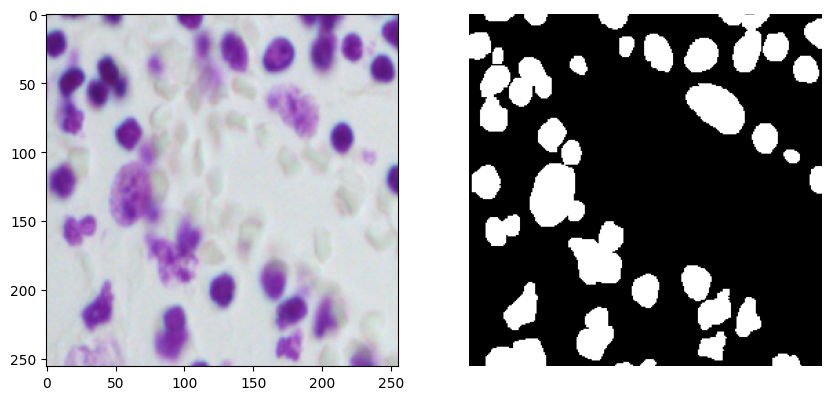

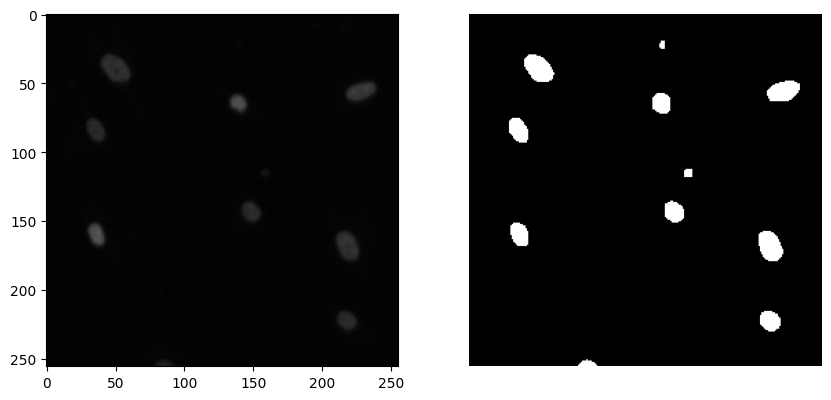

In [124]:
show_image(5,x_train,y_train)
show_image(75,x_train,y_train)

# Modèle UNET

In [125]:
from tensorflow.keras import backend as K
def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    #Casting to float32 to resolve the type error
    y_true_f = tf.cast(y_true_f, dtype=tf.float32)
    y_pred_f = tf.cast(y_pred_f, dtype=tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    # Ensure denominator is not zero by adding a small value(1e-6) to avoid division by zero errors
    result = (2. * intersection + 1e-6) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + 1e-6)
    return result

from tensorflow.keras.losses import BinaryCrossentropy

# Create a BinaryCrossentropy object
bce = BinaryCrossentropy()

In [126]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
x_train_pre = preprocess_input(x_train)
x_val_pre = preprocess_input(x_val)

# define model pre-trained
pretr_model = sm.Unet(BACKBONE, encoder_weights='imagenet')
pretr_model.compile(
    'Adam',
    loss=bce,
    metrics=[dice_coefficient],
)

In [128]:
import tensorflow as tf
from livelossplot import PlotLossesKeras
plotlossesdeeper = PlotLossesKeras()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, mode='auto') #Stop training when a monitored metric has stopped improving.

checkpoint_filepath = os.path.join(root,data_dir_path,'best_pretr_model.keras')
Model_check = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto') #Callback to save the Keras model or model weights at some frequency.

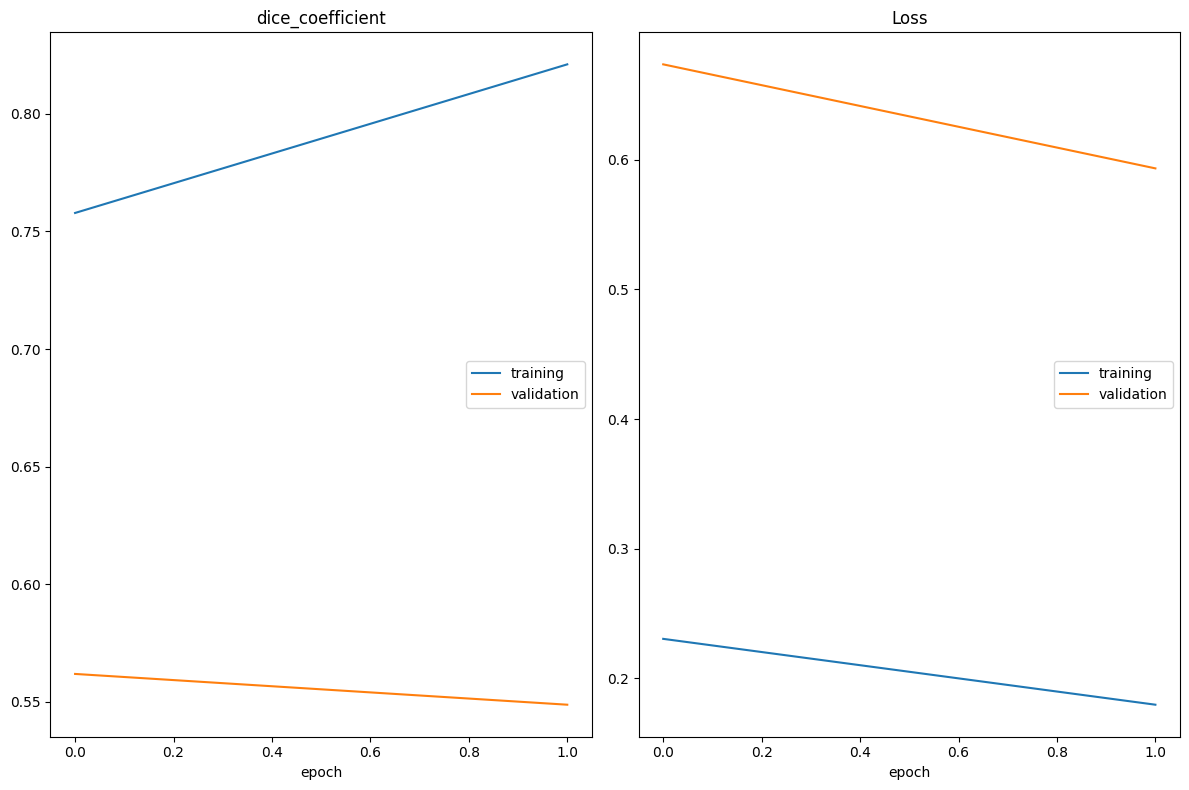

dice_coefficient
	training         	 (min:    0.758, max:    0.821, cur:    0.821)
	validation       	 (min:    0.549, max:    0.562, cur:    0.549)
Loss
	training         	 (min:    0.180, max:    0.230, cur:    0.180)
	validation       	 (min:    0.593, max:    0.674, cur:    0.593)

Epoch 2: val_loss improved from 0.67357 to 0.59333, saving model to /MyDrive/Segmentation/best_pretr_model.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 43s 178ms/step - dice_coefficient: 0.8230 - loss: 0.1769 - val_dice_coefficient: 0.5488 - val_loss: 0.5933


In [129]:
pretr_model.fit(
   x=x_train_pre,
   y=y_train,
   batch_size=4,
   epochs=2,
   validation_data=(x_val_pre, y_val),
   callbacks=[plotlossesdeeper,early_stop,Model_check]
)

In [130]:
model_best = tf.keras.models.load_model(checkpoint_filepath,custom_objects={'dice_coefficient': dice_coefficient})
res_ = model_best.evaluate(X_test,Y_test,return_dict=True) #Evaluation of the model on the test dataset
print(res_)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 450ms/step - dice_coefficient: 0.1125 - loss: 0.8833
{'dice_coefficient': 0.11987068504095078, 'loss': 0.8466633558273315}


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 765ms/step


100%|██████████| 9/9 [00:12<00:00,  1.35s/it]

Optimizing threshold for predicted probability maps


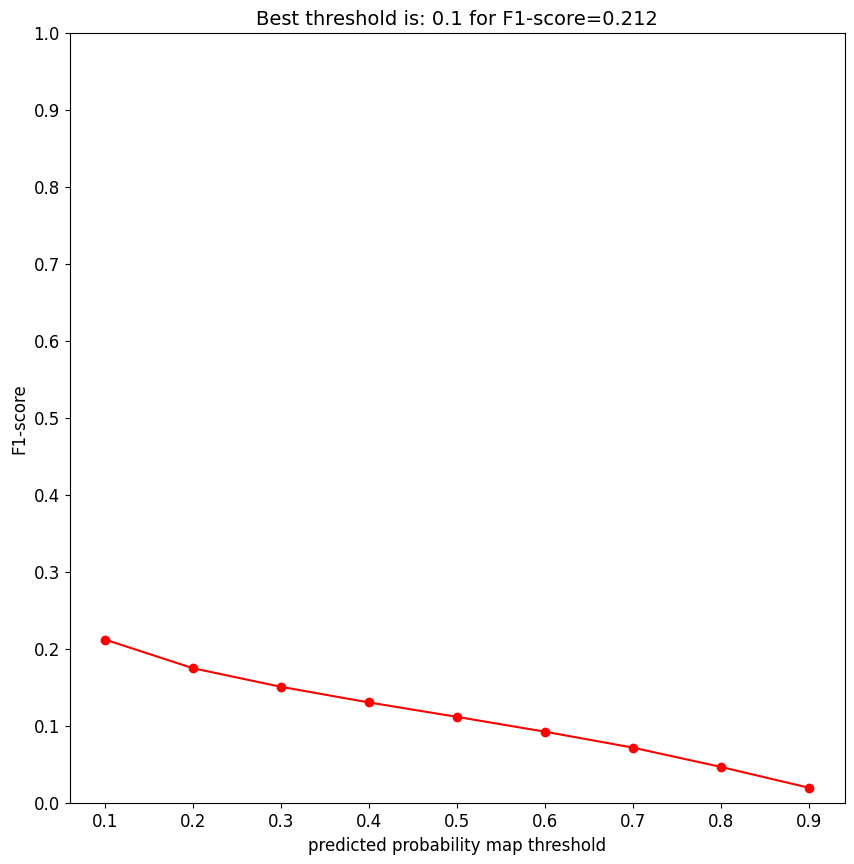

In [131]:
preds_val = model_best.predict(x_val, verbose=1)
thr_optimize(preds_val)

In [132]:
preds_test = model_best.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.1).astype(np.uint8)

dice = K.get_value(dice_coefficient(Y_test, preds_test_t))
print("Dice coefficient:", np.around(dice,3))

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step
Dice coefficient: 0.198


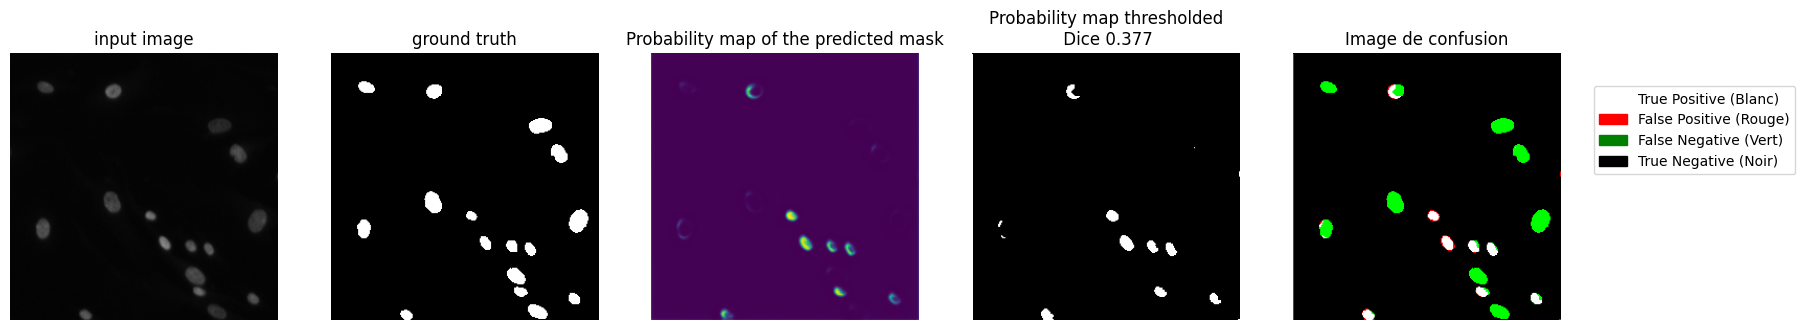

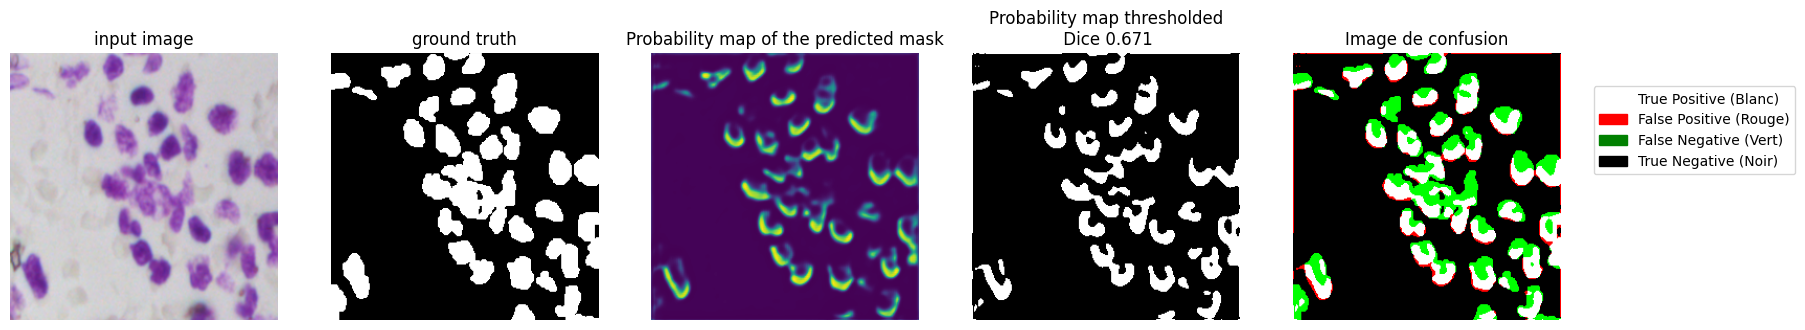

In [133]:
pred_vis(X_test,Y_test,preds_test,preds_test_t)
pred_vis(X_test,Y_test,preds_test,preds_test_t)

## Analyse des résultats

Dice for bright images 0.46043992 0.18562716
Dice for dark images 0.17607224 0.22942488


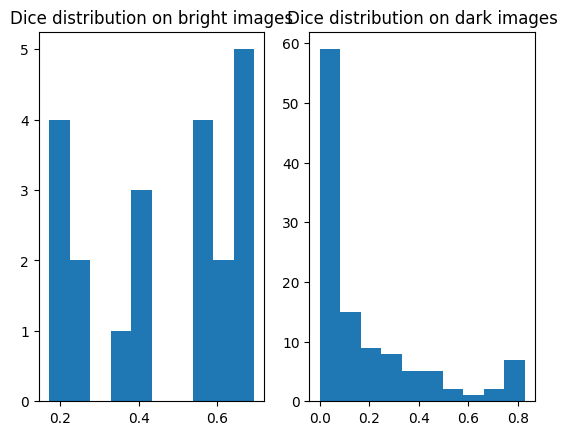

In [134]:
from skimage.color import rgb2gray

# dark_threshold = 0.19
bright_threshold = 0.5

light_intensity = []
dice_ = []
for ix in range(X_test.shape[0]):
  gray_image = rgb2gray(X_test[ix,...])
  average_intensity = np.mean(gray_image)
  dice = K.get_value(dice_coefficient(Y_test[ix,...], preds_test_t[ix,...]))
  if average_intensity < .5:
      light_intensity.append("dark")
      dice_.append(dice)
  else:
      light_intensity.append("bright")
      dice_.append(dice)

light_intensity = np.array(light_intensity)
dice_ = np.array(dice_)
print('Dice for bright images',np.mean(dice_[light_intensity=='bright']),np.std(dice_[light_intensity=='bright']))
print('Dice for dark images',np.mean(dice_[light_intensity=='dark']),np.std(dice_[light_intensity=='dark']))

plt.subplot(1,2,1)
plt.hist(dice_[light_intensity=='bright'])
plt.title('Dice distribution on bright images')
plt.subplot(1,2,2)
plt.hist(dice_[light_intensity=='dark'])
plt.title('Dice distribution on dark images')
# Show the plot
plt.show()

Le modèle est moins performant sur les images sombres. On va identifier les images sombres dans le train et appliquer

**Data augmentation**

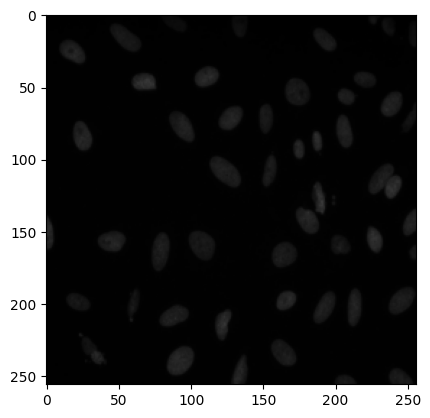

In [119]:
from skimage.color import rgb2gray

light_intensity = []
for ix in range(x_train.shape[0]):
  gray_image = rgb2gray(x_train[ix,...])
  average_intensity = np.mean(gray_image)
  if average_intensity < .5:
      light_intensity.append("dark")
  else:
      light_intensity.append("bright")

light_intensity = np.array(light_intensity)
x_train_luminosity = x_train[light_intensity=='dark']
y_train_luminosity = y_train[light_intensity=='dark']
plt.imshow(x_train_luminosity[5,:,:,:3])

Dataset description
Before data augmentation
x_train shape: (428, 256, 256, 3)
y_train shape: (428, 256, 256, 1)
After data augmentation
x_train shape: (779, 256, 256, 3)
y_train shape: (779, 256, 256, 1)


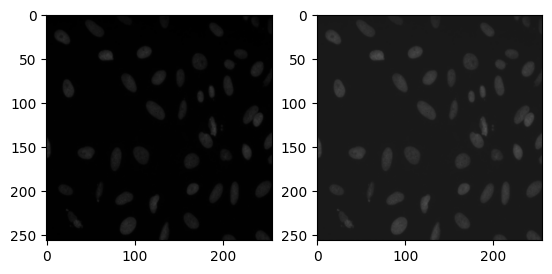

In [120]:
# prompt: code avec albumentation augmenter la luminosité sur x_train et le mask aussi


# Define the augmentation pipeline
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.9, p=1),
])

# Apply augmentation to x_train and y_train
augmented_x_train = []
augmented_y_train = []

for i in range(len(x_train_luminosity)):
  transformed = transform(image=x_train_luminosity[i], mask=y_train_luminosity[i].astype('uint8'))
  augmented_x_train.append(transformed['image'])
  augmented_y_train.append(transformed['mask'])

augmented_x_train = np.array(augmented_x_train)
augmented_y_train = np.array(augmented_y_train)

new_x_train = np.concatenate([x_train,augmented_x_train],axis=0)
new_y_train = np.concatenate([y_train,augmented_y_train],axis=0)
print('Dataset description')
print('Before data augmentation')
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('After data augmentation')
print('x_train shape:', new_x_train.shape)
print('y_train shape:', new_y_train.shape)

plt.subplot(1,2,1)
plt.imshow(x_train_luminosity[5,:,:,:3])
plt.subplot(1,2,2)
plt.imshow(augmented_x_train[5,:,:,:3])